In [1]:
# Import libraries générales
from random import sample
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Import data
data_path = "../data/"
df = pd.read_pickle(data_path+"df_2017_avec_auteurs.pkl")

In [3]:
# Choix du corpus
dfh = df[df.rubrique.apply(lambda x : x in set(df.rubrique.head(5)))]
corpus = dfh.question
len(corpus)

1158

In [4]:
# Rubriques correspondantes sous forme d'entier
l_r = list(dfh.rubrique.unique())
dic_r = {l_r[i] : i for i in range(len(l_r))}
rubint = dfh.rubrique.apply(lambda x : dic_r[x])

In [5]:
# Groupes correspondants sous forme d'entier
l_g = list(dfh.groupe_auteur.unique())
dic_g = {l_g[i] : i for i in range(len(l_g))}
groupint = dfh.groupe_auteur.apply(lambda x : dic_g[x])

In [6]:
# DataFrame stockant tous les vecteurs
# VECTORS = pd.DataFrame(columns = ['type','option','vector'])
all_vecs = []

In [7]:
# DataFrame stockant toutes les partitions
# PARTITIONS = pd.DataFrame(columns = ['method','options','culsters'])
all_parts = []

# 1. Vecteurs

## 1.0. TF, TFIDF

In [8]:
# Import for Vectorizer
from stop_words import get_stop_words
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
stop_words = get_stop_words('french')

In [9]:
# Calcul du TF-IF (pour brut, lsa, nmf ...)
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
tfidf = tfidf_vectorizer.fit_transform(corpus)
tfidf_vectors = tfidf.toarray()
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
# VECTORS.loc['tfidf'] = ['tfidf',None,tfidf_vectors]
all_vecs.append(['tfidf',None,tfidf_vectors])

In [10]:
# Calcul du TF (pour LDA)
tf_vectorizer = CountVectorizer(stop_words=stop_words)
tf = tf_vectorizer.fit_transform(corpus)
tf_vectors = tf.toarray()
tf_feature_names = tf_vectorizer.get_feature_names()
# VECTORS.loc['tf'] = ['tf',None,tf_vectors]
all_vecs.append(['tf',None,tf_vectors])

## 1.1 ACP

In [11]:
# Import for PCA
from sklearn.decomposition import PCA

In [12]:
# PCA TF IDF
n_components = 10
pca = PCA(n_components=n_components, random_state=0)
reduced_features_tfidf = pca.fit_transform(tfidf_vectors)
all_vecs.append(['pca_tfidf',n_components,reduced_features_tfidf])

In [13]:
# PCA TF
random_state = 0
dim_pca_tf = 10
pca = pca = PCA(n_components=dim_pca_tf, random_state=0)
reduced_features_tf = pca.fit_transform(tf_vectors)
all_vecs.append(['pca_tf',dim_pca_tf,reduced_features_tf])
# VECTORS.loc['pcatf'] = ['pca_tf',n_components,reduced_features_tf]
# VECTORS.loc['pcatfidf'] = ['pca_tfidf',n_components,reduced_features_tfidf]

## 1.2. LSA

In [14]:
from sklearn.decomposition import TruncatedSVD

In [15]:
dim_lsa = 10 # Pas bon du tout, tenter de voir les meilleures valeurs singulières
svd_model = TruncatedSVD(n_components=dim_lsa, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(tfidf.T)
lsa_doc_vectors = svd_model.fit_transform(tfidf)

In [16]:
# VECTORS.loc['lsa10'] = ['lsa',dim_lsa,lsa_doc_vectors]
all_vecs.append(['lsa',dim_lsa,lsa_doc_vectors])

## 1.3. LDA

In [17]:
from sklearn.decomposition import LatentDirichletAllocation

In [18]:
n_topics_lda = 10
lda_doc_model = LatentDirichletAllocation(n_components=n_topics_lda, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf.T)
lda_doc_vectors = lda_doc_model.components_.T

In [19]:
# VECTORS.loc['lda10'] = ['lda',n_topics_lda,lda_doc_vectors]
all_vecs.append(['lda',n_topics_lda,lda_doc_vectors])

## 1.4. NMF

In [20]:
from sklearn.decomposition import NMF

In [21]:
n_topics_nmf = 10
nmf_doc_model = NMF(n_components=n_topics_nmf, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf.T)
nmf_doc_vectors = nmf_doc_model.components_.T

In [22]:
# VECTORS.loc['nmf10'] = ['nmf',n_topics_nmf,nmf_doc_vectors]
all_vecs.append(['nmf',n_topics_nmf,nmf_doc_vectors])

# 2. Clustering

In [23]:
# Scores de clustering
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

## 2.1 K-means

In [24]:
from sklearn.cluster import MiniBatchKMeans

In [25]:
# Exécution du k-means
def go_kmeans(vectors, k = 5):
    random_state = 0
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(vectors)
    return kmeans

# Get the clusters of a kmeans
def get_clusters_kmeans(vectors, k=5, kmeans = None):
    if kmeans is None :
        kmeans = go_kmeans(vectors, k = 5)
    return kmeans.predict(vectors)

## 2.2 Hiérarchique

In [26]:
from sklearn.cluster import AgglomerativeClustering

In [27]:
# Get the clusters of a HAC
def get_clusters_HAC(vectors, n_clusters, linkage, affinity):
    aggc = AgglomerativeClustering(linkage=linkage, affinity=affinity, n_clusters=n_clusters)
    aggc = aggc.fit(vectors)
    return aggc.labels_

## 2.3 X-means

In [28]:
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster import cluster_visualizer

In [29]:
# Get the clusters of a xmeans
def execute_xmeans(vectors,kmin,kmax):
    amount_initial_centers = kmin
    initial_centers = kmeans_plusplus_initializer(vecs, amount_initial_centers).initialize()

    xmeans_instance = xmeans(vecs, initial_centers, kmax)
    xmeans_instance.process()

    groupes = xmeans_instance.get_clusters()
    clusters = pd.Series(
        {j : i for i,m in enumerate(xmeans_tfidf_clusters_grouped) for j in m}
    ).sort_index().values
    
    return clusters

# 3 Combinaisons

## 3.1 Éxécution de certaines partitions

In [30]:
for i, (name, option, vector) in enumerate(all_vecs) :
    if name != 'tf' and name != 'tfidf':
        for k in [5,10,15]:
            print(name,option,k,'...')
            all_parts.append([name,'kmeans',k,get_clusters_kmeans(vector,k)])
            all_parts.append([name, 'agg average', k,get_clusters_HAC(vector,k,'average','cosine')])
            all_parts.append([name, 'agg complete', k,get_clusters_HAC(vector,k,'complete','cosine')])  
print('fin')

pca_tfidf 10 5 ...
pca_tfidf 10 10 ...
pca_tfidf 10 15 ...
pca_tf 10 5 ...
pca_tf 10 10 ...
pca_tf 10 15 ...
lsa 10 5 ...
lsa 10 10 ...
lsa 10 15 ...
lda 10 5 ...
lda 10 10 ...
lda 10 15 ...
nmf 10 5 ...
nmf 10 10 ...
nmf 10 15 ...
fin


## 3.2 Comparaison des partitions

In [31]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.cluster import adjusted_rand_score

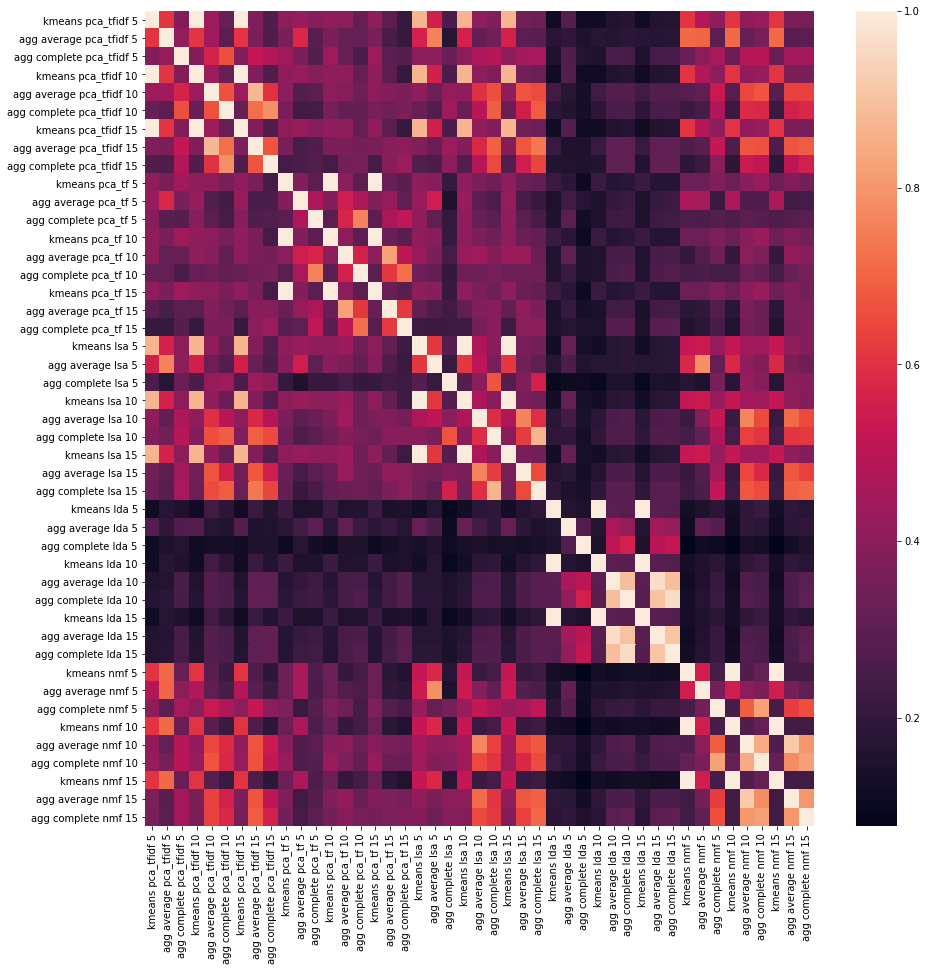

In [32]:
plt.figure(figsize = (15,15))
selection = all_parts
pt = pd.DataFrame(selection,columns = ['vec','method','opt','clusters'])
partitions = np.array([i[3] for i in selection])
matrix_ARI = pairwise_distances(partitions,metric = adjusted_rand_score)
sns.heatmap(matrix_ARI, xticklabels=pt.method+' '+pt.vec+' ' +pt.opt.apply(str), yticklabels=pt.method+' '+pt.vec+' '+pt.opt.apply(str));

## 3.3 Combiner les partitions

In [ ]:
import Cluster_Ensembles as CE
cluster_runs = np.random.randint(0, 50, (50, 15000))
consensus_clustering_labels = CE.cluster_ensembles(cluster_runs, verbose = True, N_clusters_max = 50)
consensus_clustering_labels
# Reduce dans functools pour Python3 mais pas Python2

In [42]:
import openensembles as oe

In [44]:
dataObj = oe.data(partitions)

TypeError: __init__() missing 1 required positional argument: 'x'